In [38]:
from analysis.load_dataset import build_tg_data
import numpy as np
import torch
import pandas as pd
import torch_geometric as tg
import torch.nn.functional as F
from sklearn import metrics
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import to_networkx, from_networkx


import networkx as nx
import matplotlib.pyplot as plt


In [14]:
def evaluate(y_truth,y_pred):
    auc = metrics.roc_auc_score(y_truth, y_pred, multi_class='ovo',labels=[0,1],average='macro')
    ap = metrics.average_precision_score(y_truth, y_pred, average='macro', pos_label=1, sample_weight=None)
    return ap,auc
def process_data(data,max_time_steps=32):
    data.edge_time = data.edge_time-data.edge_time.min() #process edge time
    data.edge_time = data.edge_time/data.edge_time.max()
    data.edge_time = (data.edge_time*max_time_steps).long()
    data.edge_time = data.edge_time.view(-1,1).float()
    
    
    edge = torch.cat([data.edge_index,data.edge_time.view(1,-1)],dim=0) #process node time
    degree = pd.DataFrame(edge.T.numpy()).groupby(0).min().values
    ids = pd.DataFrame(data.edge_index.T.numpy()).groupby(0).count().index.values 
    key = {}
    for i in range(data.x.shape[0]):
        key[i]=0
    for i in range(len(ids)):
        key[ids[i]]=degree[i][1]
    node_time = np.array(list(key.values()))
    data.node_time=torch.tensor(node_time)
    
    # trans to undirected graph
    data.edge_index = torch.cat((data.edge_index,data.edge_index[[1,0],:]),dim=1)
    data.edge_time = torch.cat((data.edge_time,data.edge_time),dim=0)

    return data

In [15]:
datapath = './dataset/DGraphFin/raw/dgraphfin.npz'
origin_data = np.load(datapath)
data = build_tg_data(is_undirected=False,datapath=datapath)
data = process_data(data)

device = torch.device('cpu')

In [16]:
data

Data(x=[3700550, 17], y=[3700550], edge_index=[2, 8601998], train_mask=[857899], val_mask=[183862], test_mask=[183840], edge_time=[8601998, 1], node_time=[3700550])

In [17]:
labels = data.y
# 获取每个标签对应的节点索引
label_indices = {}
unique_labels = labels.unique()

for label in unique_labels:
    label_indices[label.item()] = torch.nonzero(labels == label).view(-1)

# 打印每个标签对应的节点索引
for label, indices in label_indices.items():
    print(f"Label {label}: Node indices {indices}, shape {indices.shape}")

Label 0: Node indices tensor([      7,      13,      21,  ..., 3700381, 3700533, 3700541]), shape torch.Size([1210092])
Label 1: Node indices tensor([   1343,    1605,    1744,  ..., 3566027, 3566155, 3686679]), shape torch.Size([15509])
Label 2: Node indices tensor([      0,       2,       4,  ..., 3700547, 3700548, 3700549]), shape torch.Size([1620851])
Label 3: Node indices tensor([      1,       3,       5,  ..., 3699958, 3700226, 3700265]), shape torch.Size([854098])


In [18]:
normal, fraud, back1, back2 = label_indices[0], label_indices[1], label_indices[2], label_indices[3]

normal.shape, fraud.shape, back1.shape, back2.shape

(torch.Size([1210092]),
 torch.Size([15509]),
 torch.Size([1620851]),
 torch.Size([854098]))

In [19]:
labels, labels.shape

(tensor([2, 3, 2,  ..., 2, 2, 2]), torch.Size([3700550]))

In [ ]:
g1 = to_networkx(data, to_undirected=True, edge_attrs=data.edge_time.squeeze(dim=0))
g1

In [20]:
g = to_networkx(data, to_undirected=True)
g

In [21]:
list(g.nodes())[:5]

[0, 1, 2, 3, 4]

In [22]:
normal_l = list(normal.numpy().tolist())
fraud_l = list(fraud.numpy().tolist())
back1_l = list(back1.numpy().tolist())
back2_l = list(back2.numpy().tolist())
normal_l[:10]


[7, 13, 21, 25, 30, 34, 37, 38, 39, 48]

#### 局部子图结构分析

In [43]:


def ego_plot(g, ego_nodes, radius):

    # 设置子图的行和列
    num_rows = 3
    num_cols = 3

    # 创建一个新的图形
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

    for i, node in enumerate(ego_nodes):
        # 计算子图在图中的位置
        row = i // num_cols
        col = i % num_cols

        ego_subgraph = nx.ego_graph(g, node, radius)

        # 创建一个节点标签的字典，设置橙色、绿色和红色的节点
        node_colors = ['g' if n in normal_l else 'r' if n in fraud_l else 'blue' if n in back1_l else 'orange' for n in ego_subgraph.nodes()]

        # 使用布局算法绘制ego子图
        pos = nx.spring_layout(ego_subgraph)
        
        # 绘制ego子图到相应的子图位置
        nx.draw(ego_subgraph, pos, with_labels=True, node_size=150, ax=axes[row, col], node_color=node_colors, font_size=6)
        
        # 设置标题
        axes[row, col].set_title(f'Ego Subgraph for Node {node}')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图
    plt.show()


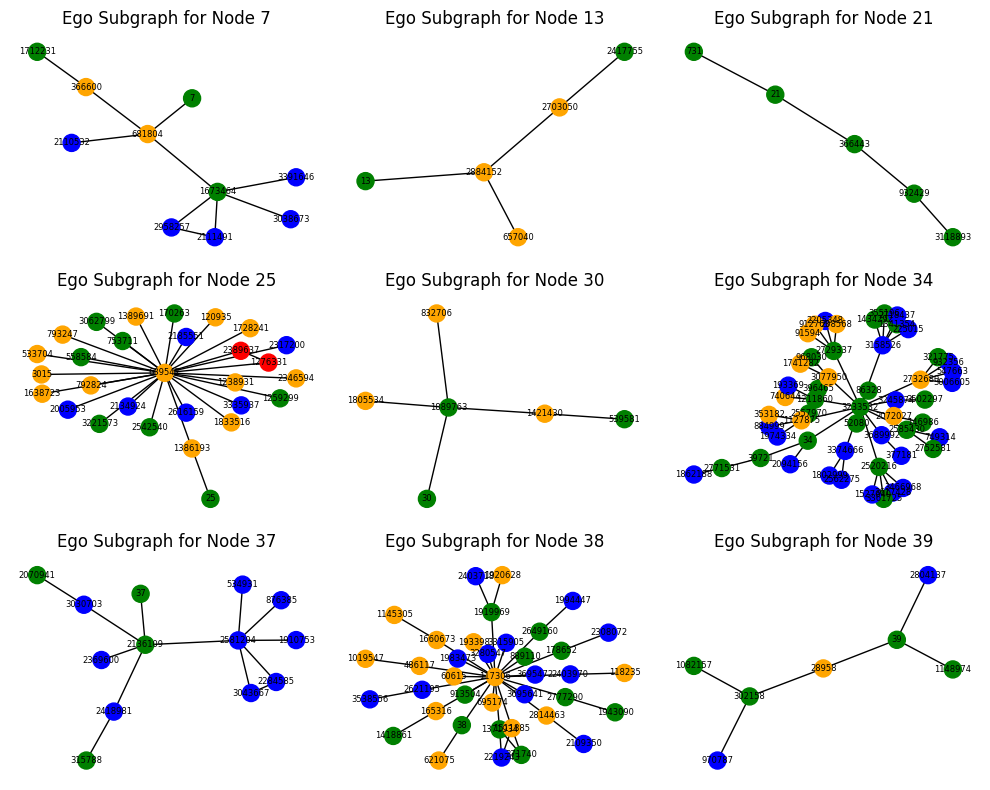

In [44]:
ego_plot(g, normal_l[:9], radius=3)

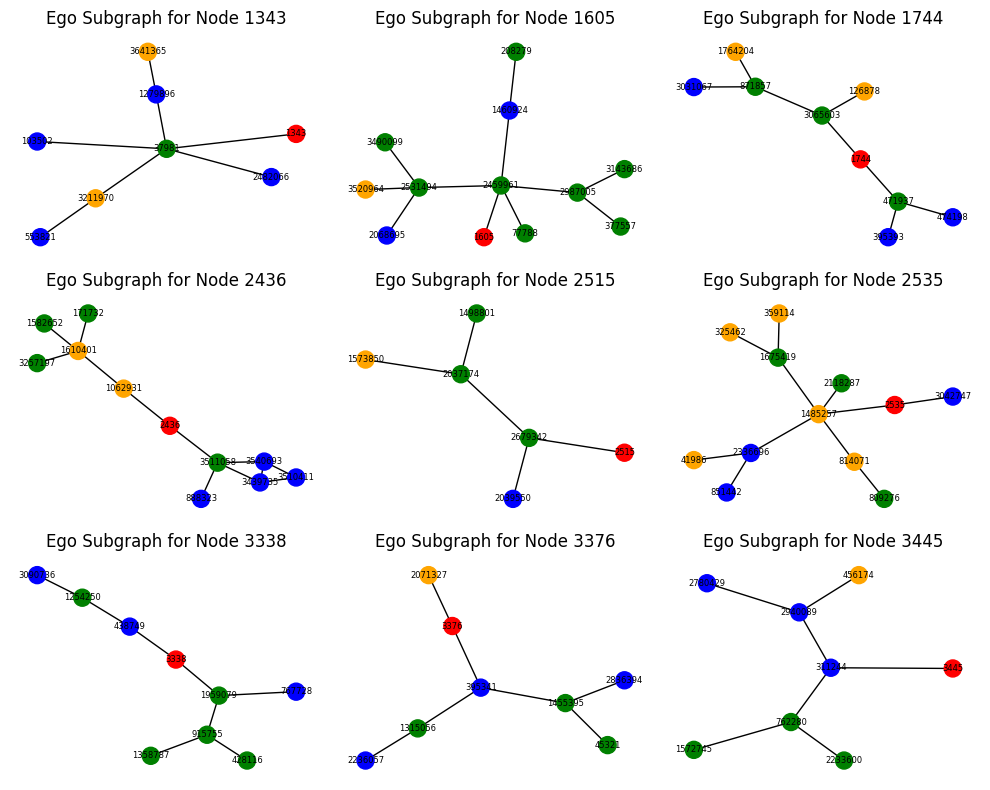

In [45]:
ego_plot(g, fraud_l[:9], radius=3)

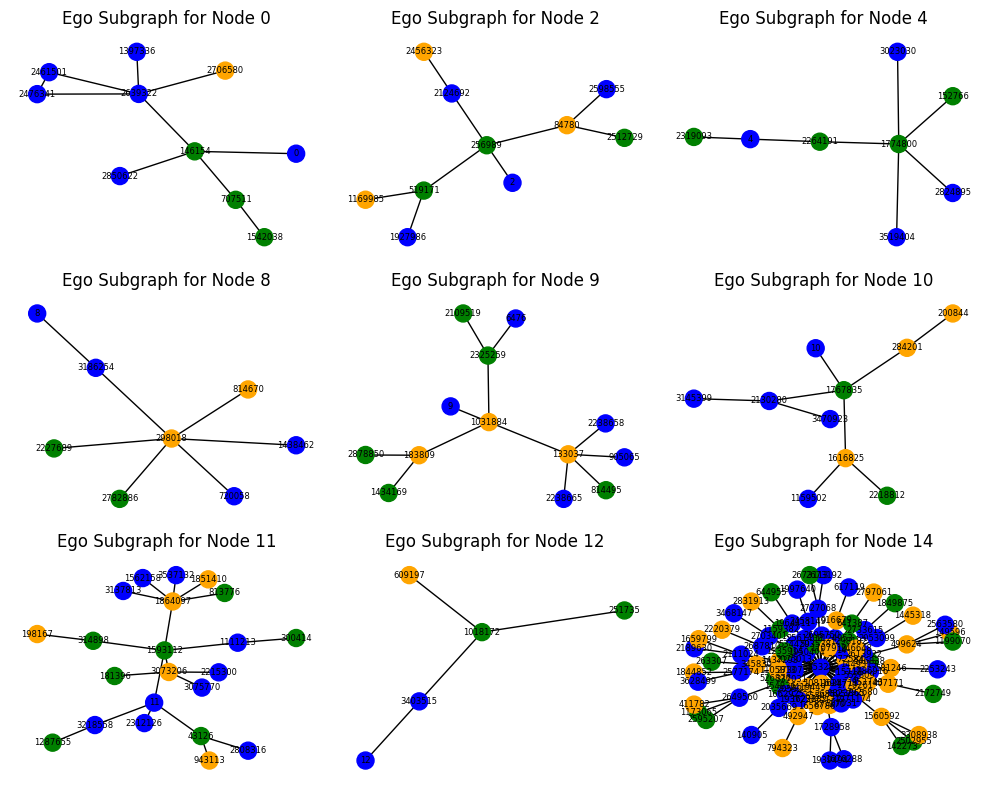

In [46]:
ego_plot(g, back1_l[:9], radius=3)

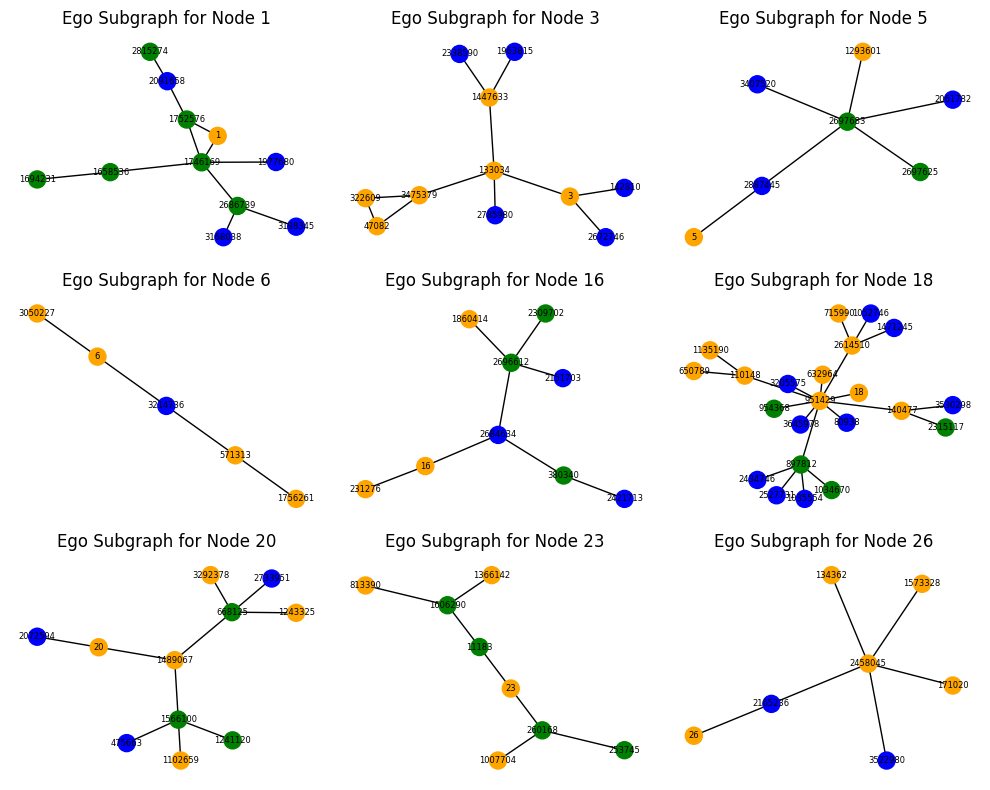

In [47]:
ego_plot(g, back2_l[:9], radius=3)

#### 节点属性分析

In [ ]:
data.x.shape

In [ ]:
def feats_plot(data, node_idx):
    # 定义子图的行和列数
    num_rows = 4  # 4行
    num_cols = 5  # 5列

    # 创建一个新的图形
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

    # 遍历每列特征并绘制其分布
    for i in range(17):
        row = i // num_cols
        col = i % num_cols
        
        feature_values = data.x[node_idx, i].numpy()
        
        # 绘制特征列的直方图
        axes[row, col].hist(feature_values, bins=50, alpha=0.5, color='b', edgecolor='black')
        axes[row, col].set_title(f'Feature {i} Distribution')
        axes[row, col].set_xlabel('Feature Value')
        axes[row, col].set_ylabel('Frequency')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图
    plt.show()

In [ ]:
feats_plot(data, normal)

In [ ]:
feats_plot(data, fraud)

In [ ]:
feats_plot(data, back1)

In [ ]:
feats_plot(data, back2)

In [ ]:
num_samples = data.x.shape[0]
# 将数据集分成多个块
block_size = 100  # 每个块的大小
num_blocks = num_samples // block_size

similarities = np.zeros((num_samples, num_samples))  # 存储相似性矩阵

for i in range(num_blocks):
    for j in range(i, num_blocks):
        start_i = i * block_size
        end_i = (i + 1) * block_size
        start_j = j * block_size
        end_j = (j + 1) * block_size
        
        # 获取两个块的数据
        block1 = data[start_i:end_i]
        block2 = data[start_j:end_j]
        
        # 计算块之间的余弦相似性
        block_similarity = cosine_similarity(block1, block2)
        
        # 更新相似性矩阵
        similarities[start_i:end_i, start_j:end_j] = block_similarity
        similarities[start_j:end_j, start_i:end_i] = block_similarity.T

In [ ]:
# 计算余弦相似性
def cosine_similarity(matrix):
    dot_product = np.dot(matrix, matrix.T)
    norms = np.linalg.norm(matrix, axis=1)
    norms_matrix = np.outer(norms, norms)
    similarity_matrix = dot_product / norms_matrix
    return similarity_matrix

# 计算余弦相似性矩阵
cosine_sim_matrix = cosine_similarity(data.x)

# 绘制热力图
plt.imshow(cosine_sim_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Heatmap")
plt.show()

#### 时序信息分析

In [23]:
edge_time = data.edge_time
edge_index = data.edge_index
edge_time.shape, edge_index.shape

(torch.Size([8601998, 1]), torch.Size([2, 8601998]))

In [ ]:
def sort_edges(edge_index, edge_time):
    sorted_time, time_indices = torch.sort(edge_time, dim=0)
    unique_time = torch.unique(sorted_time)
    sorted_edge = edge_index.t()[time_indices]
    
    data = tg.data.Data()

    

    

In [42]:
sorted_time[sorted_time==0].shape, sorted_time[sorted_time==1].shape

(torch.Size([242214]), torch.Size([280984]))

In [28]:
# 使用 torch.sort 进行排序
sorted_time, time_indices = torch.sort(edge_time, dim=0)
sorted_time, time_indices

(tensor([[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [32.],
         [32.],
         [32.]]),
 tensor([[ 809090],
         [1721329],
         [1721328],
         ...,
         [ 306405],
         [  59215],
         [1107847]]))

In [35]:
# 使用 torch.unique 获取唯一值和它们的索引
unique_values, unique_indices = torch.unique(sorted_time, return_inverse=True)
unique_values, unique_values.shape

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32.]),
 torch.Size([33]))

In [36]:
unique_indices, unique_indices.shape

(tensor([[ 0],
         [ 0],
         [ 0],
         ...,
         [32],
         [32],
         [32]]),
 torch.Size([8601998, 1]))

In [37]:
unique_values[unique_indices]

tensor([[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [32.],
        [32.],
        [32.]])

In [32]:
edge_index.t()[0]

tensor([ 476699, 2915516])

In [33]:
sorted_edge = edge_index.t()[time_indices]
sorted_edge

tensor([[[2057056,  646759]],

        [[1592240, 1479904]],

        [[ 710357, 1378202]],

        ...,

        [[1427226, 2579274]],

        [[ 349565, 1948492]],

        [[2915490, 3684134]]])

In [34]:
sorted_edge[0]

tensor([[2057056,  646759]])

In [30]:
# 初始化一个时间间隔变量
current_time = 0

# 存储每个时刻的节点和连边
time_to_nodes = {}
time_to_edges = {}

for i in range(len(sorted_time)):
    # 获取当前时间
    time = sorted_time[i]
    
    # 获取当前时间间隔内的边
    current_edges.append(edge_index[:, i])
    
    # 获取当前时间间隔内的节点
    current_nodes.update(edge_index[:, i])
    
    # 存储当前时间的节点和连边
    time_to_nodes[time] = set(current_nodes)
    time_to_edges[time] = list(current_edges)
    
    # 更新当前时间间隔
    current_time = time

: 